# ML Models to Predict No-shows Among Medical Appointments
Peter Le

## Contents:

    1. Business Problem/Question
    2. Objective
    3. Required Libraries
    4. Available Data
    5. EDA and Data Preprocessing
    6. Feature Engineering
    7. Build and evaluate ML Models 
            - Random Forest, 
            - Naive Bayes, 
            - Logistic Regression, 
            - Artificial Neural Network
    9. Conclusion

## 1. Business Problem/Question

- No-shows are preventable waste of limited healthcare resources
- Can we predict someone to no-show an appointment?

## 2. Objective

- Find the best ML model in predicting no-shows among medical appointments using historical dataset of of 300k medical appointments available on Kaggle

## 3. Required Libraries

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

from IPython.display import Image

import itertools

In [5]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__)
%matplotlib inline

3.9.0


In [7]:
# Cufflinks is for easy interactive Pandas charting with Plotly. 
# Cufflinks binds Plotly directly to pandas dataframes
import cufflinks as cf
init_notebook_mode(connected=True) # For Notebooks
cf.go_offline() # For offline use

sns.set_style("whitegrid")

## 4. Available Data

Data set consists of 300k medical appointments and its 15 variables (characteristics) of each.

Data Dictionary
    • PatientId : Patient unique Id
    • AppointmentID : Appointment ID of a patient
    • Gender : Male or Female
    • ScheduledDay : The day it was scheduled
    • AppointmentDay : The day of an appointment
    • Age : How old is the patient
    • Neighbourhood : Where the appointment takes place
    • Scholarship : True or False 
    • Hipertension : True or False 
    • Diabetes : True or False 
    • Alcoholism : True or False 
    • Handcap : True or False 
    • SMS_received : 1 or more messages sent to the patient
    • No-show : No or Yes
    


In [8]:
# Load and view the dataset
df = pd.read_csv('MedApptNoShow.csv')
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0   29872499824296        5642903      F  2016-04-29T18:38:08Z   
1  558997776694438        5642503      M  2016-04-29T16:08:27Z   
2    4262962299951        5642549      F  2016-04-29T16:19:04Z   
3     867951213174        5642828      F  2016-04-29T17:29:31Z   
4    8841186448183        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

## 5. EDA and Data Preprocessing

In [9]:
# Check NUll values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: int64(9), object(5)
memory usage: 11.8+ MB


In [10]:
sum(df.isnull().sum())

0

In [11]:
# Check outliers
# Notes: Describe only looks at numeric variables, not date/time or string variables
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921800e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [12]:
# Remove age values of -1 and ages greater than 100 
df=df[(df['Age']>=0) & (df['Age']<100)]

In [13]:
# Correct typos in some column names
df.rename(columns = {'Hipertension': 'Hypertension', 'No-show': 'NoShowStatus', 'Handcap': 'Handicap'}, inplace = True)
print(df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'NoShowStatus'],
      dtype='object')


In [14]:
# Format Scheduled day and Appointment day into datatime
# Scheduled day and Appointment day can be splitted into Hour of the day of the appointment and day of the week for appointment 
df['ScheduledDay'] = df['ScheduledDay'].apply(np.datetime64)
df['AppointmentDay'] = df['AppointmentDay'].apply(np.datetime64)

In [16]:
# Transform the data 
pv = df.pivot_table(values=["Diabetes","Alcoholism","Hypertension","Handicap"],columns="NoShowStatus",index="MonthNumber",aggfunc=np.sum)
df_pv = pv.unstack().unstack('NoShowStatus').reset_index().rename(columns={"level_0":"Category"})
df_pv["NoShowRate"] = df_pv['Yes'] / (df_pv['Yes'] + df_pv['No'])  #Yes --> No-Show, No --> Show-Up
df_pv.head()

NoShowStatus    Category  MonthNumber    No   Yes  NoShowRate
0             Alcoholism            4    87    16    0.155340
1             Alcoholism            5  1916   497    0.205968
2             Alcoholism            6   680   164    0.194313
3               Diabetes            4   200    41    0.170124
4               Diabetes            5  4669  1073    0.186869

In [17]:
# Plot trends in the data 
Diabetes = df_pv[df_pv['Category'] == 'Diabetes']
Alcoholism = df_pv[df_pv['Category'] == 'Alcoholism']
Handicap = df_pv[df_pv['Category'] == 'Handicap']
Hypertension = df_pv[df_pv['Category'] == 'Hypertension']

line1 = go.Scatter(
    x= Diabetes['MonthNumber'],
    y=Diabetes['NoShowRate']*100,
    mode= 'lines+markers',
    text=Diabetes['Category'],
    name="Diabetes")

line2 = go.Scatter(
    x= Alcoholism['MonthNumber'],
    y=Alcoholism['NoShowRate']*100,
    mode= 'lines+markers',
    text=Alcoholism['Category'],
    name="Alcoholism")

line3 = go.Scatter(
    x= Handicap['MonthNumber'],
    y=Handicap['NoShowRate']*100,
    mode= 'lines+markers',
    text=Handicap['Category'],
    name='Handicap')

line4 = go.Scatter(
    x= Hypertension['MonthNumber'],
    y=Hypertension['NoShowRate']*100,
    mode= 'lines+markers',
    text=Hypertension['Category'],
    name='Hypertension')


layout = dict(title = "No Shows",hovermode='closest',xaxis=dict({"title":"Months"}),
             yaxis=dict({"title":"No Show Rate (Percentage)"}))
dat = [line1,line2,line3,line4]
fig = go.Figure(data=dat,layout=layout)
iplot(fig,filename='basic-line')

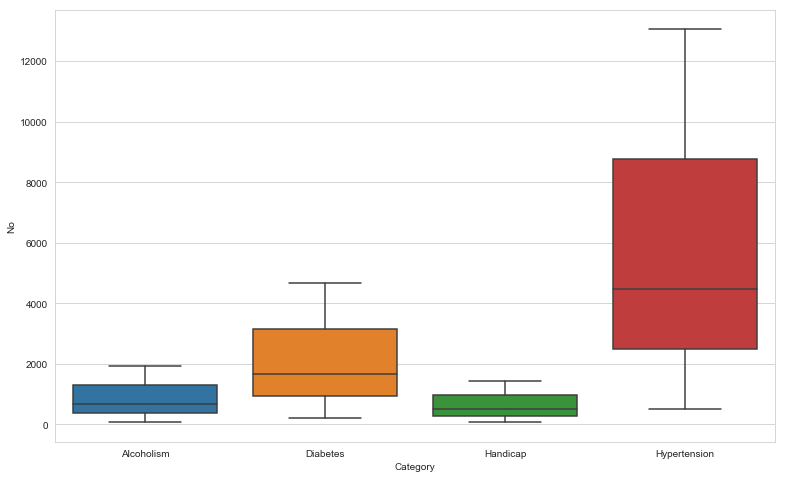

In [18]:
figure = plt.figure(figsize=(10,6))
ax = figure.add_axes([0,0,1,1])
sns.boxplot(x="Category",y="No",data=df_pv)  # No --> Show-Up

#sns.violinplot(x="Category", y="No", data=df_pv,palette='rainbow')
#sns.swarmplot(x="Category", y="No", data=df_pv,color='black',size=3)

From the above, We can notice that Patient Id is not unique, implies that some patients schedule multiple appointments.

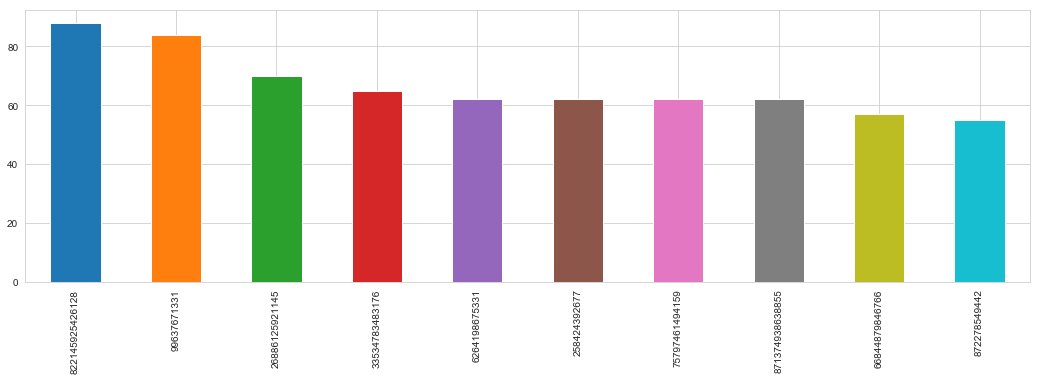

In [20]:
df['PatientId'].value_counts().head(10).plot(kind='bar',figsize=(18,5))

Mean number of appointments per patient:	1.6342328747331074
Median number of appointments per patient:	1.0


<function matplotlib.pyplot.show(*args, **kw)>

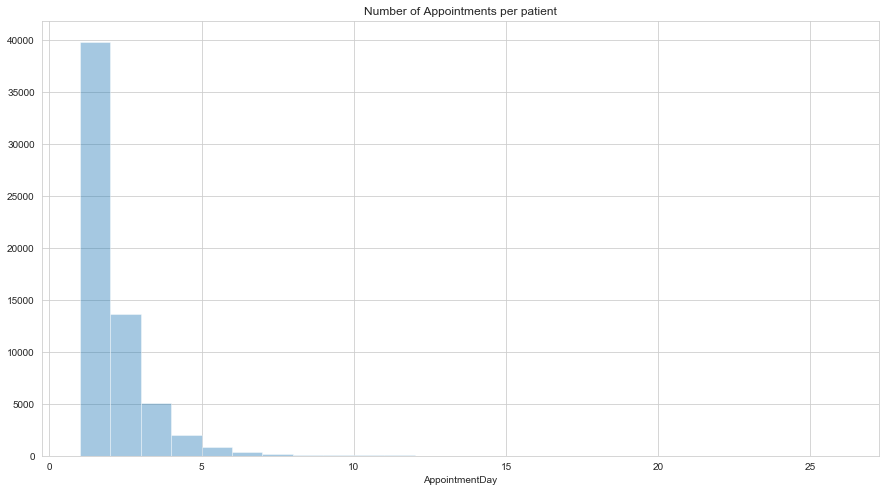

In [21]:
# Histogram of number of appointments per patient
x = df.groupby('PatientId')['AppointmentDay'].nunique()

print('Mean number of appointments per patient:\t%s' %np.mean(x))
print('Median number of appointments per patient:\t%s' %np.median(x))
plt.figure(figsize=(15,8))
sns.distplot(x, bins = x.nunique(), kde=False)
plt.title("Number of Appointments per patient")
plt.show

In [22]:
# Appointment ID is unique and that makes sense because for each appointment, unique Id is generated.
len(df.AppointmentID) == len(df.AppointmentID.unique())

True

In [23]:
# Check distribution of the days between the appointment scheduled and appointment date. 
print(df['#DaysFromSchToAppt'].value_counts().head(5))
df['#DaysFromSchToAppt'].iplot(kind='hist',bins=50)

0 days    38560
2 days     6724
4 days     5290
1 days     5211
7 days     4906
Name: #DaysFromSchToAppt, dtype: int64


In [25]:
# Count shows and no-shows
print (df['NoShowStatus'].value_counts())
layout_1 = cf.Layout(height=500, 
                     width=500, 
                     title= 'Count of Show-up and No-show')

no_show_plot = df['NoShowStatus'].value_counts().iplot(kind='bar', 
                                                       xTitle = 'No Show Status', 
                                                       yTitle= 'Count', 
                                                       theme = 'polar', 
                                                       layout = layout_1,
                                                       legend=True, 
                                                       color = 'red')

No     88199
Yes    22316
Name: NoShowStatus, dtype: int64


In [22]:
## Check Show and no-show by gender
No_Show_Gender=df.groupby(['Gender','NoShowStatus'])['NoShowStatus'].size()
print(No_Show_Gender)
layout_2 = cf.Layout(height=600,
                     width=500, 
                     barmode='stack',
                     title= 'Count of Show-up and No-show based on Gender')

No_Show_Gender_plot=df.groupby(['Gender','NoShowStatus'])['NoShowStatus'].size().unstack().iplot(kind='bar', 
                                                                                                 xTitle = 'Gender', 
                                                                                                 yTitle= 'Count',
                                                                                                 layout = layout_2)

Gender  NoShowStatus
F       No              57239
        Yes             14591
M       No              30960
        Yes              7725
Name: NoShowStatus, dtype: int64


In [26]:
# Visualize differences between genders
reason = df[['Gender','Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']].groupby(['Gender']).sum()
print(reason)
reason_plot = df[['Gender','Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']].groupby(['Gender']).sum().iplot(kind='bar')

        Hypertension  Diabetes  Alcoholism  Handicap
Gender                                              
F              15338      5606        1223      1400
M               6462      2337        2137      1053


Text(0.5, 1.0, 'Visit to the doctor based on Gender')

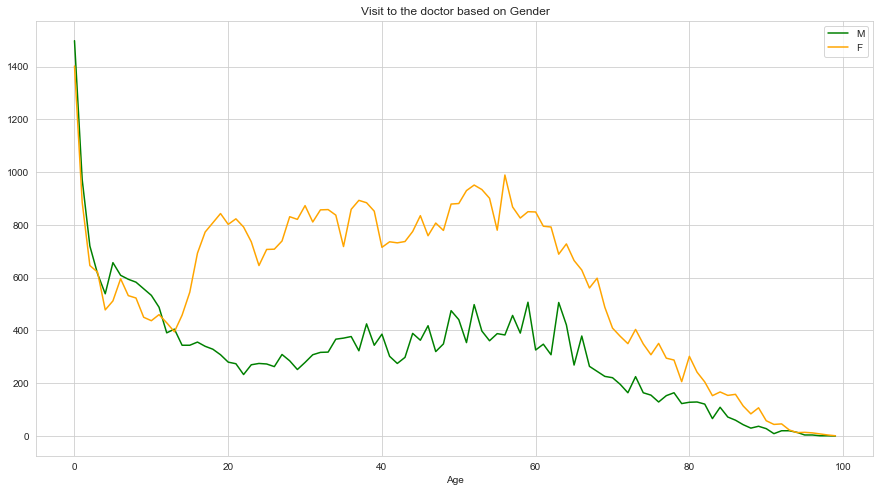

In [27]:
# Check age and no-shows
df1 = df.copy()
df1 = df1[df1.NoShowStatus == 'No'].copy()
range_df1 = pd.DataFrame()
range_df1['Age'] = range(100)
men = range_df1['Age'].apply(lambda x: len(df1[(df1['Age'] == x) & (df1['Gender'] == 'M')]))
women = range_df1['Age'].apply(lambda x: len(df1[(df1['Age'] == x) & (df1['Gender'] == 'F')]))
plt.figure(figsize=(15,8))
plt.plot(range(100),men, 'green')
plt.plot(range(100),women, color = 'orange')
plt.legend(['M','F'])
plt.xlabel('Age')
plt.title('Visit to the doctor based on Gender')

Monday 22712
Tuesday 25637
Wednesday 25866
Thursday 17244
Friday 19017
Saturday 39


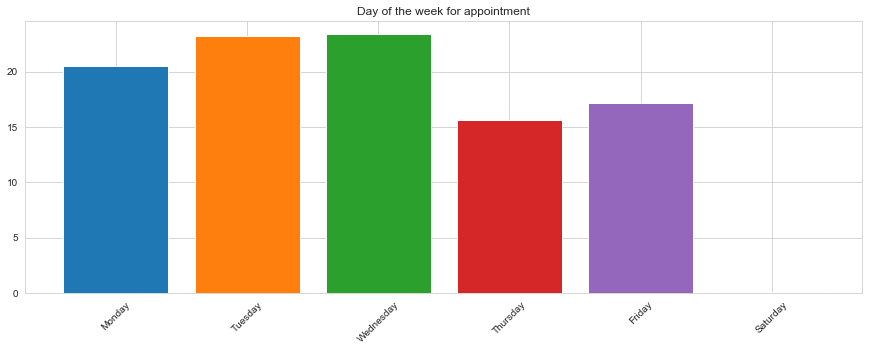

In [28]:
# Check appointments by days of the week
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize=(15,5))
for index,i in enumerate(weekdays):
    j=df[df['DayOfTheWeek']==i]
    count=len(j)
    total_count=len(df)
    perc=(count/total_count)*100
    print(i,count)
    plt.bar(index,perc)
plt.xticks(range(len(weekdays)),weekdays, rotation=45)
plt.title('Day of the week for appointment')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

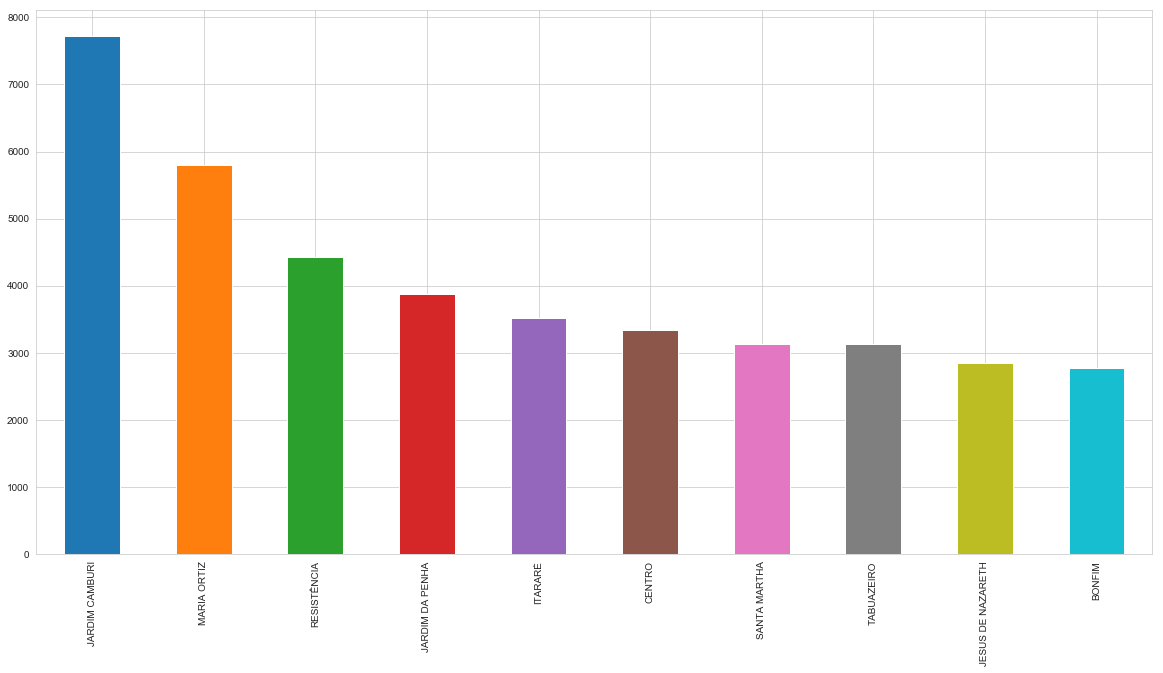

In [29]:
# Check now-shows by location of hospitals 
location = df.groupby(['Neighbourhood'],sort=True).size()
# print(location.sort_values())
df['Neighbourhood'].value_counts().head(10).plot(kind='bar',figsize=(20,10))
plt.xticks(rotation=90)

## 6. Feature Engineering

### Create new features:
    - number of days from registration to appointment
    - day of the week for an appointment 
    - hour and date for the appointment scheduled

In [15]:
# Define a function to calculate hour from timestamp
def calculate_hour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

# Define a function to separate date from timestamp
def separate_date(day):
    day=str(day)
    day=str(day[:10])
    return day

df['HourOfTheDay'] = df.ScheduledDay.apply(calculate_hour)
df['ScheduledDate'] = df.ScheduledDay.apply(separate_date)
df['AppointmentDay'] = df.AppointmentDay.apply(separate_date)

# Calculate the day of the week and difference of days between scheduled day and appointment day
df['ScheduledDate'] = df['ScheduledDate'].apply(np.datetime64)
df['ScheduledDate'] = pd.to_datetime(df['ScheduledDate'])

df['AppointmentDay'] = df['AppointmentDay'].apply(np.datetime64)
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['MonthNumber'] = df['AppointmentDay'].dt.month

df['#DaysFromSchToAppt'] = df['AppointmentDay'] - df['ScheduledDate']
df['DayOfTheWeek'] = df['AppointmentDay'].dt.weekday_name
df.tail()

PatientId  AppointmentID Gender        ScheduledDay  \
110522    2572134369293        5651768      F 2016-05-03 09:15:35   
110523    3596266328735        5650093      F 2016-05-03 07:27:33   
110524   15576631729893        5630692      F 2016-04-27 16:03:52   
110525   92134931435557        5630323      F 2016-04-27 15:09:23   
110526  377511518121127        5629448      F 2016-04-27 13:30:56   

       AppointmentDay  Age Neighbourhood  Scholarship  Hypertension  Diabetes  \
110522     2016-06-07   56   MARIA ORTIZ            0             0         0   
110523     2016-06-07   51   MARIA ORTIZ            0             0         0   
110524     2016-06-07   21   MARIA ORTIZ            0             0         0   
110525     2016-06-07   38   MARIA ORTIZ            0             0         0   
110526     2016-06-07   54   MARIA ORTIZ            0             0         0   

        Alcoholism  Handicap  SMS_received NoShowStatus  HourOfTheDay  \
110522           0         0             1           No             9   
110523           0         0             1           No             7   
110524           0         0             1           No            16   
110525           0         0             1           No            15   
110526           0         0             1           No            14   

       ScheduledDate  MonthNumber #DaysFromSchToAppt DayOfTheWeek  
110522    2016-05-03            6            35 days      Tuesday  
110523    2016-05-03            6            35 days      Tuesday  
110524    2016-04-27            6            41 days      Tuesday  
110525    2016-04-27            6            41 days      Tuesday  
110526    2016-04-27            6            41 days      Tuesday

In [19]:
# Check the PatientId
len(df.PatientId) == len(df.PatientId.unique())

False

### Drop features not useful for ML models

In [30]:
no_show = df.copy()

# Dropping the non-predictors
no_show.drop(['PatientId','AppointmentID', 'AppointmentDay','ScheduledDay', 'ScheduledDate', '#DaysFromSchToAppt', 
              'SMS_received','Neighbourhood','MonthNumber'], inplace=True, axis=1)

In [31]:
no_show.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110515 entries, 0 to 110526
Data columns (total 10 columns):
Gender          110515 non-null object
Age             110515 non-null int64
Scholarship     110515 non-null int64
Hypertension    110515 non-null int64
Diabetes        110515 non-null int64
Alcoholism      110515 non-null int64
Handicap        110515 non-null int64
NoShowStatus    110515 non-null object
HourOfTheDay    110515 non-null int64
DayOfTheWeek    110515 non-null object
dtypes: int64(7), object(3)
memory usage: 9.3+ MB


In [32]:
no_show['Gender'] = no_show['Gender'].apply(lambda x: 1 if x == 'M' else 0)
no_show['NoShowStatus'] = no_show['NoShowStatus'].apply(lambda x: 1 if x == 'Yes' else 0)
no_show.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110515 entries, 0 to 110526
Data columns (total 10 columns):
Gender          110515 non-null int64
Age             110515 non-null int64
Scholarship     110515 non-null int64
Hypertension    110515 non-null int64
Diabetes        110515 non-null int64
Alcoholism      110515 non-null int64
Handicap        110515 non-null int64
NoShowStatus    110515 non-null int64
HourOfTheDay    110515 non-null int64
DayOfTheWeek    110515 non-null object
dtypes: int64(9), object(1)
memory usage: 9.3+ MB


In [ ]:
### Plot feature importance, distribution of each attributes, 

In [33]:
# label Encoding is performed for categorical attributes
df_plt = no_show.copy()
df_plt = df_plt.select_dtypes(exclude=['number']) \
                .apply(LabelEncoder().fit_transform)\
                .join(df_plt.select_dtypes(include=['number']))
df_plt.head()

DayOfTheWeek  Gender  Age  Scholarship  Hypertension  Diabetes  Alcoholism  \
0             0       0   62            0             1         0           0   
1             0       1   56            0             0         0           0   
2             0       0   62            0             0         0           0   
3             0       0    8            0             0         0           0   
4             0       0   56            0             1         1           0   

   Handicap  NoShowStatus  HourOfTheDay  
0         0             0            19  
1         0             0            16  
2         0             0            16  
3         0             0            17  
4         0             0            16

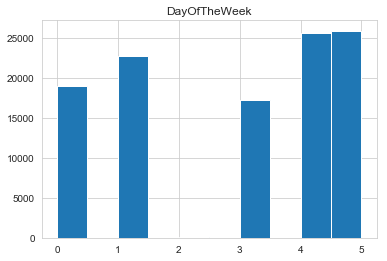

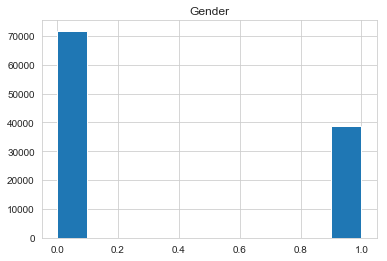

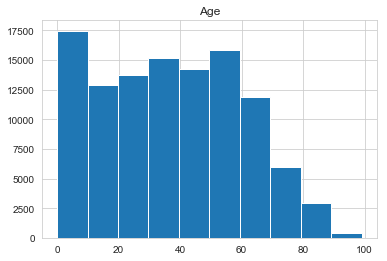

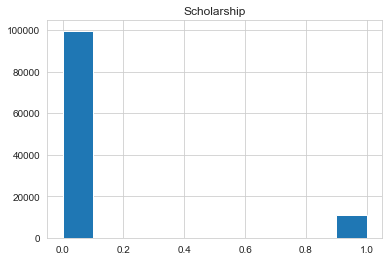

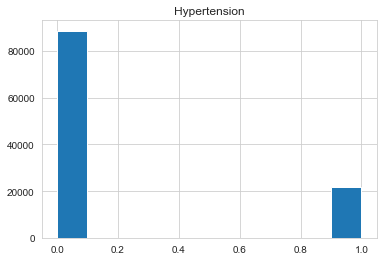

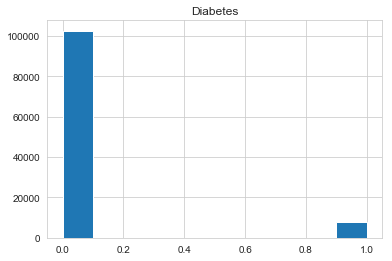

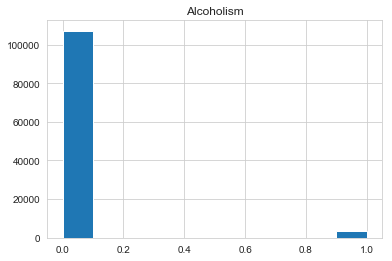

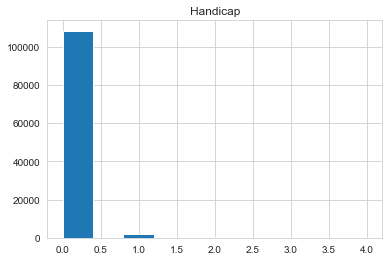

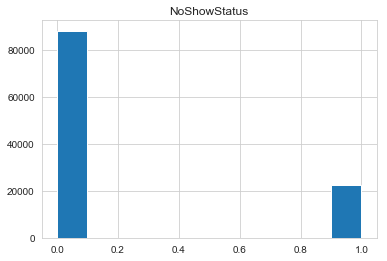

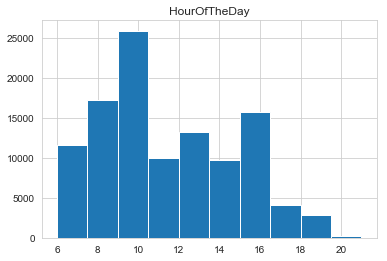

In [34]:
# Histogram of the predictive features
# Forgot th code to stack multiple graphs in a line :)
cols= df_plt.columns
for i in cols:
 df_plt.hist(i)
 plt.show()

### Correlation Matrix Plot

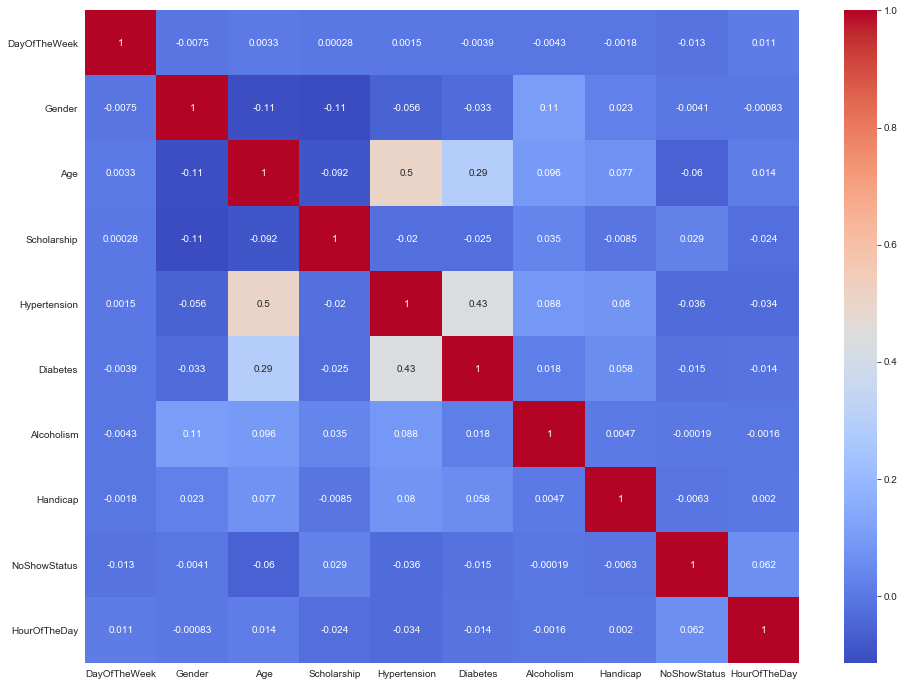

In [35]:
plt.figure(figsize=(16,12))
sns.heatmap(df_plt.corr(),cmap='coolwarm', annot=True)

The matrix shows possitive correlation between age and hypertensionas well as hypertension and diabetes

### Plot Feature Importance Using Random Forest

In [36]:
y_pt = df_plt.pop('NoShowStatus')
X_pt = pd.DataFrame(df_plt)

In [37]:
y_pt.nunique()

2

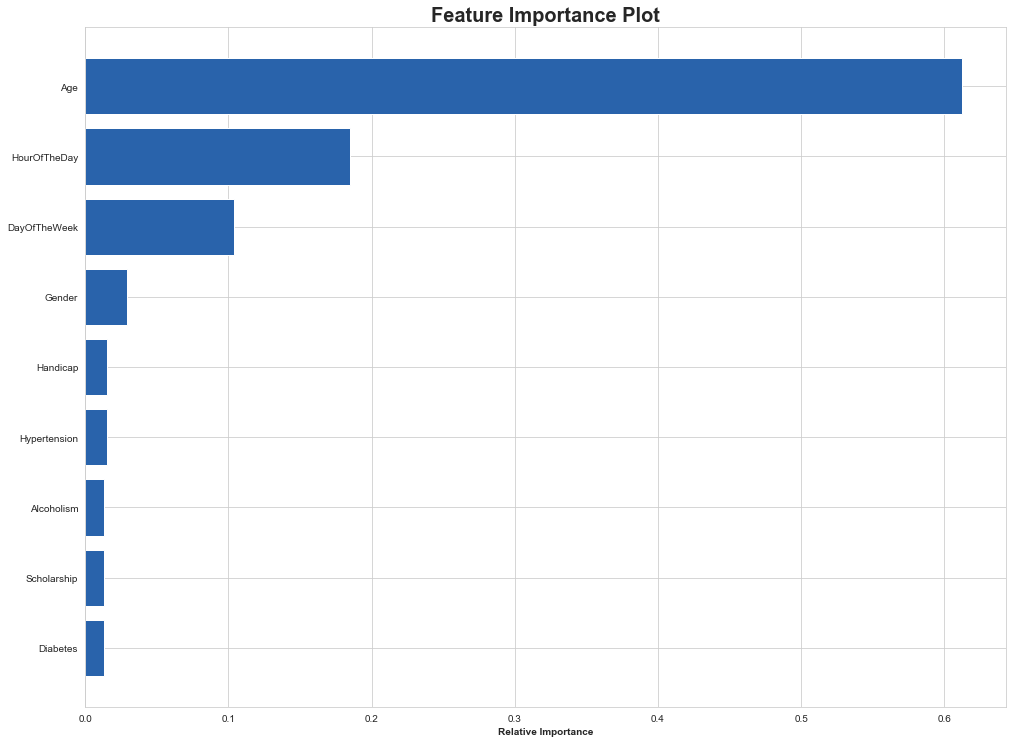

In [38]:
clf_random = RandomForestClassifier(random_state=122, criterion = 'entropy')
clf_random.fit(X_pt,y_pt)
features = X_pt.columns
importances = clf_random.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importance Plot',fontsize=20,fontweight="bold")
plt.barh(range(len(indices)), importances[indices], color='#2963ab', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance',fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(16.5, 12.5, forward=True)
plt.show()

Age, HourOfTheDay and DayOfTheWeek appear to be the top important features in predicting labels

In [39]:
# Generate dummies for "DayOfTheWeek"
dow = pd.get_dummies(no_show['DayOfTheWeek'], prefix="DOW")
no_show = no_show.select_dtypes(exclude=['object']) \
                .join(dow)
no_show.head()

Gender  Age  Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
0       0   62            0             1         0           0         0   
1       1   56            0             0         0           0         0   
2       0   62            0             0         0           0         0   
3       0    8            0             0         0           0         0   
4       0   56            0             1         1           0         0   

   NoShowStatus  HourOfTheDay  DOW_Friday  DOW_Monday  DOW_Saturday  \
0             0            19           1           0             0   
1             0            16           1           0             0   
2             0            16           1           0             0   
3             0            17           1           0             0   
4             0            16           1           0             0   

   DOW_Thursday  DOW_Tuesday  DOW_Wednesday  
0             0            0              0  
1             0            0              0  
2             0            0              0  
3             0            0              0  
4             0            0              0

In [40]:
y = no_show.pop('NoShowStatus')
X = pd.DataFrame(no_show)

In [41]:
X.head()

Gender  Age  Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
0       0   62            0             1         0           0         0   
1       1   56            0             0         0           0         0   
2       0   62            0             0         0           0         0   
3       0    8            0             0         0           0         0   
4       0   56            0             1         1           0         0   

   HourOfTheDay  DOW_Friday  DOW_Monday  DOW_Saturday  DOW_Thursday  \
0            19           1           0             0             0   
1            16           1           0             0             0   
2            16           1           0             0             0   
3            17           1           0             0             0   
4            16           1           0             0             0   

   DOW_Tuesday  DOW_Wednesday  
0            0              0  
1            0              0  
2            0              0  
3            0              0  
4            0              0

In [42]:
y.value_counts(True)

0    0.798073
1    0.201927
Name: NoShowStatus, dtype: float64

NoShowStatus class apprear to be imbalance.

### Use SMOTETomek to handle the class imbalance 

In [44]:
# Over-sample using SMOTE and clean using Tomek links to generate more class imbalance data
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=111)
X_res, y_res = smt.fit_sample(X, y)
from collections import Counter
print('Resampled dataset size {}'.format(sorted(Counter(y_res).items())))

Resampled dataset size [(0, 88137), (1, 88137)]


In [45]:
X_res.shape

(176274, 14)

In [46]:
y_res = np.reshape(y_res,(len(y_res),1))
y_res.shape

(176274, 1)

### Use MinMaxScaler to Scale the Variables
Normalized varaibles with different range of values - i.e., bringing it  all the on the same scale - using MinMax Scaler from sklearn library.

__MinMaxScaler__ 
- scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one. 
- often used as an alternative to zero mean, unit variance scaling.

- The transformation formula:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min
```
where min, max = feature_range.

In [47]:
scaler = MinMaxScaler()
scaled_X_res = scaler.fit_transform(X_res)
#Train and valid splits
X_train,X_test,y_train,y_test = train_test_split(scaled_X_res,y_res,test_size=0.25, random_state = 5555)

C:\Users\quynhle\AppData\Local\Continuum\miniconda3\envs\peterle\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



### Define a function to plot confusion matrix

In [48]:
sns.set_style('white')

## Confusion Matrix
class_names = ['Show-Up', 'No-Show']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 7. Build and evaluate various ML Models 

### Random Forest

In [49]:
clf_ran = RandomForestClassifier(random_state=122)
clf_ran.fit(X_train,y_train)

C:\Users\quynhle\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=122, verbose=0, warm_start=False)

_____________________________________________________________
Accuracy score on train data: 0.750902
Accuracy score on test data: 0.676053
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65     22080
           1       0.65      0.75      0.70     21989

   micro avg       0.68      0.68      0.68     44069
   macro avg       0.68      0.68      0.67     44069
weighted avg       0.68      0.68      0.67     44069

_____________________________________________________________
Confusion matrix, without normalization
[[13337  8743]
 [ 5533 16456]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.25 0.75]]


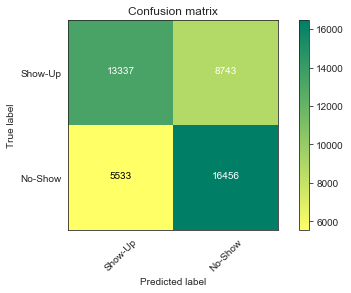

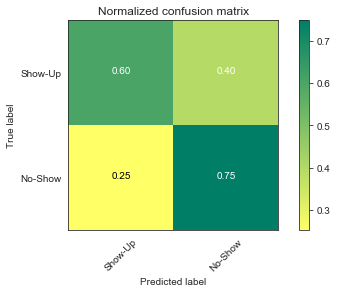

In [50]:
y_pred_ran_train = clf_ran.predict(X_train)
y_pred_ran_test = clf_ran.predict(X_test)

acc_ran_train = metrics.accuracy_score(y_train, y_pred_ran_train)
acc_ran_test = metrics.accuracy_score(y_test, y_pred_ran_test)
rp_ran = metrics.classification_report(y_test, y_pred_ran_test)
print("_____________________________________________________________")
print("Accuracy score on train data: {:5f}".format(acc_ran_train))
print("Accuracy score on test data: {:5f}".format(acc_ran_test))
print("Classification Report:")
print(rp_ran)
print("_____________________________________________________________")

# Compute confusion matrix
cnf_mat_rf = confusion_matrix(y_test, y_pred_ran_test)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_mat_rf, classes=class_names,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_mat_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Naive Bayes

C:\Users\quynhle\AppData\Local\Continuum\miniconda3\envs\peterle\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



_____________________________________________________________
Accuracy score on train data: 0.557921
Accuracy score on test data: 0.558488
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.37      0.46     22080
           1       0.54      0.75      0.63     21989

   micro avg       0.56      0.56      0.56     44069
   macro avg       0.57      0.56      0.54     44069
weighted avg       0.57      0.56      0.54     44069

_____________________________________________________________
Confusion matrix, without normalization
[[ 8140 13940]
 [ 5517 16472]]
Normalized confusion matrix
[[0.37 0.63]
 [0.25 0.75]]


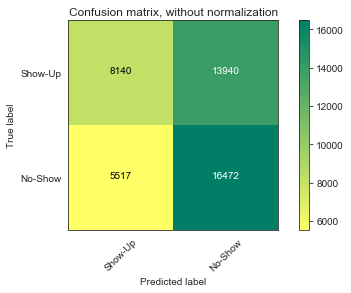

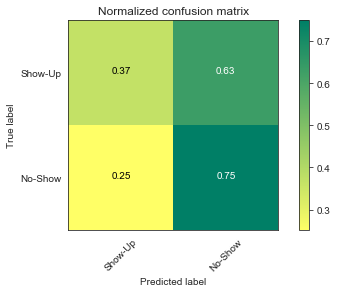

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

clf_nb =  MultinomialNB().fit(X_train, y_train)

y_pred_nb_train = clf_nb.predict(X_train)
y_pred_nb_test = clf_nb.predict(X_test)

acc_nb_train = metrics.accuracy_score(y_train, y_pred_nb_train)
acc_nb_test = metrics.accuracy_score(y_test, y_pred_nb_test)
rp_nb = metrics.classification_report(y_test, y_pred_nb_test)
print("_____________________________________________________________")
print("Accuracy score on train data: {:5f}".format(acc_nb_train))
print("Accuracy score on test data: {:5f}".format(acc_nb_test))
print("Classification Report:")
print(rp_nb)
print("_____________________________________________________________")

# Compute confusion matrix
cnf_matrix_nb = confusion_matrix(y_test, y_pred_nb_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Logistic Regression (With Cross Validation)

In [ ]:
# TypeError: __init__() got multiple values for argument 'n_splits'
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(y_train,n_splits = 10, random_state = 777)
logit = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=fold
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg')
log_model = logit.fit(X_train,y_train)

In [ ]:
# TypeError: __init__() got an unexpected keyword argument 'n_folds'
fold = KFold(len(y_train), n_folds=10, shuffle=True, random_state=777)
logit = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=fold
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg')
log_model = logit.fit(X_train,y_train)

In [65]:
# So to fix the errors
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=5)
kf.get_n_splits(y_train)

5

In [66]:
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [67]:
logit = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=kf
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg')
log_model = logit.fit(X_train,y_train)

In [68]:
print("__________________________________________")
print("Max auc_roc score: {}".format(log_model.scores_[1].max()))
print("Best mean auc_roc score: {:.4f}".format(log_model.scores_[1].mean(axis=0).max()))
print("__________________________________________")

__________________________________________
Max auc_roc score: 0.6145365617027672
Best mean auc_roc score: 0.6109
__________________________________________


_____________________________________________________________
Accuracy score on train data: 0.579645
Accuracy score on test data: 0.579410
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.56     22080
           1       0.57      0.62      0.60     21989

   micro avg       0.58      0.58      0.58     44069
   macro avg       0.58      0.58      0.58     44069
weighted avg       0.58      0.58      0.58     44069

_____________________________________________________________
Confusion matrix, without normalization
[[11869 10211]
 [ 8324 13665]]
Normalized confusion matrix
[[0.54 0.46]
 [0.38 0.62]]


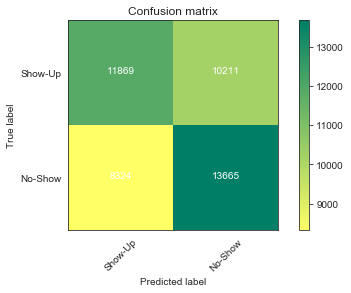

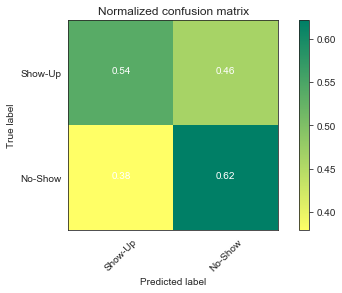

In [69]:
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)

acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
rp = metrics.classification_report(y_test, y_pred_test)
print("_____________________________________________________________")
print("Accuracy score on train data: {:5f}".format(acc_train))
print("Accuracy score on test data: {:5f}".format(acc_test))
print("Classification Report:")
print(rp)
print("_____________________________________________________________")

# Compute confusion matrix
cnf_matrix_lg = confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_lg, classes=class_names,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_lg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Artificial Neural Network

Text(0, 0.5, 'Error rate')

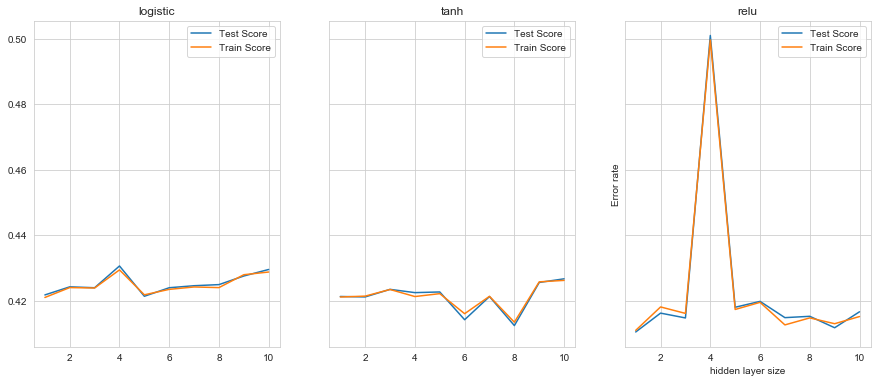

In [71]:
from sklearn.neural_network import MLPClassifier
sns.set_style('whitegrid')
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)

axs = axs.ravel()

hidden_layer_sizes = [(5), (5,5), (5,5,5), (5,2,5,2), (10), (10,5), (10,5,5), (10,5,5,3), (5,4,3), (5,3,4)]
activation = ['logistic', 'tanh', 'relu']
    
for k in range(0, len(activation)):
    
    error_test=[]
    error_train=[]
    for i in range(0, len(hidden_layer_sizes)):
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes[i], max_iter=20, activation = activation[k], tol=1e-4, random_state=23432)
    
        mlp.fit(X_train, y_train)

        error_test.append(zero_one_loss(y_test, mlp.predict(X_test)))
        error_train.append(zero_one_loss(y_train, mlp.predict(X_train)))

    axs[k].plot([1,2,3,4,5,6,7,8,9,10], error_test)
    axs[k].plot([1,2,3,4,5,6,7,8,9,10], error_train)

    axs[k].set_title(activation[k])

    axs[k].legend(['Test Score', 'Train Score'])
    
plt.xlabel("hidden layer size")
plt.ylabel("Error rate")

The best model seems to be with relu activation function and 3 layers of 10, 5 and 5 nodes each respectively.
Let's use cross validation and plot a learning curve between sample size and error to find out the presence of bias or variance!

#### Cross Validation of ANN

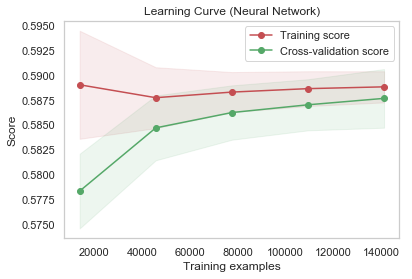

In [72]:
sns.set(style="whitegrid")

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = scaled_X_res, y_res


title = "Learning Curve (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=23432)

estimator = MLPClassifier(hidden_layer_sizes=(10,5,5), activation = 'relu', tol=1e-4, random_state=23832)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

From the above chart, we can conclude the absence of high variance as score doesn't really improve much as we increase the training set.  

_____________________________________________________________
Accuracy score on train data: 0.589857
Accuracy score on test data: 0.588078
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55     22080
           1       0.57      0.67      0.62     21989

   micro avg       0.59      0.59      0.59     44069
   macro avg       0.59      0.59      0.59     44069
weighted avg       0.59      0.59      0.59     44069

_____________________________________________________________
Confusion matrix, without normalization
[[11192 10888]
 [ 7265 14724]]
Normalized confusion matrix
[[0.51 0.49]
 [0.33 0.67]]


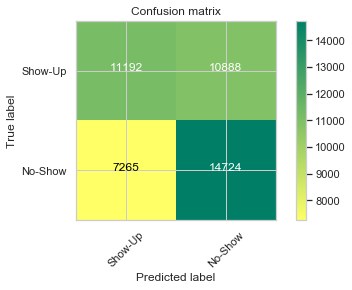

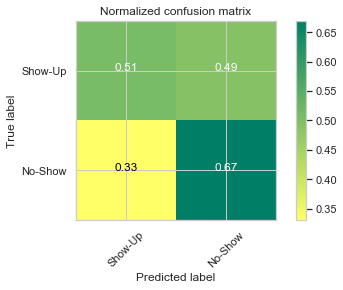

In [73]:
estimator.fit(X_train, y_train)
y_pred_ann_train = estimator.predict(X_train)
y_pred_ann_test = estimator.predict(X_test)

ann_acc_train = metrics.accuracy_score(y_train, y_pred_ann_train)
ann_acc_test = metrics.accuracy_score(y_test, y_pred_ann_test)
ann_rp = metrics.classification_report(y_test, y_pred_ann_test)
print("_____________________________________________________________")
print("Accuracy score on train data: {:5f}".format(ann_acc_train))
print("Accuracy score on test data: {:5f}".format(ann_acc_test))
print("Classification Report:")
print(ann_rp)
print("_____________________________________________________________")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_ann_test)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## 8. Conclusion

For the given historical medical appointment data and initial model-building specifications above, Random forest appears to be the best model in predicting no-show medical appointment. 

Different feature selections and further parametter tuning may results in a different insights